In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
DATA_PATH = "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v2/data/matbench_mp_e_form/data/matbench_mp_e_form.csv"
NMAX = 10
BINARIZE = True

In [3]:
def minihash(s):
    s = s.lower()
    s = re.sub('[^0-9a-zA-Z\s]+', '', s)
    s = [x for x in s.split() if x not in {'the', 'of', 'a'}]
    s = '-'.join(s)
    if BINARIZE:
        s += "-binarized-counts"
    return s

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
cols = df.columns.tolist()
els_start = cols.index("H")
els_end = cols.index("Eform")
els_cols = cols[els_start:els_end]

In [6]:
edf = df[els_cols]
print("Number of referenced elements: ", len(edf.columns))
print("All referenced elements: ", ", ".join(edf.columns.tolist()))

counts = edf.sum(0)
print("Number of elements referenced at least once: ", len(counts[counts > 0]))
print("Missing referenced elements: ", ", ".join(counts[counts == 0].index.tolist()))
print("All referenced elements: ", ", ".join(counts[counts > 0].index.tolist()))

edf = edf[counts[counts > 0].index.tolist()]
print("Pruning dataframe to only include referenced elements: ", edf.shape)

els_cols = edf.columns.tolist()

Number of referenced elements:  94
All referenced elements:  H, He, Li, Be, B, C, N, O, F, Ne, Na, Mg, Al, Si, P, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Kr, Rb, Sr, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, Cs, Ba, La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Pb, Bi, Po, At, Rn, Fr, Ra, Ac, Th, Pa, U, Np, Pu
Number of elements referenced at least once:  84
Missing referenced elements:  He, Ne, Ar, Kr, Xe, Po, At, Rn, Fr, Ra
All referenced elements:  H, Li, Be, B, C, N, O, F, Na, Mg, Al, Si, P, S, Cl, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Rb, Sr, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Cs, Ba, La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Pb, Bi, Ac, Th, Pa, U, Np, Pu
Pruning dataframe to only include referenced elements:  (132752, 84)


In [7]:
edf.sample()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
els_sum = edf.sum(0).values

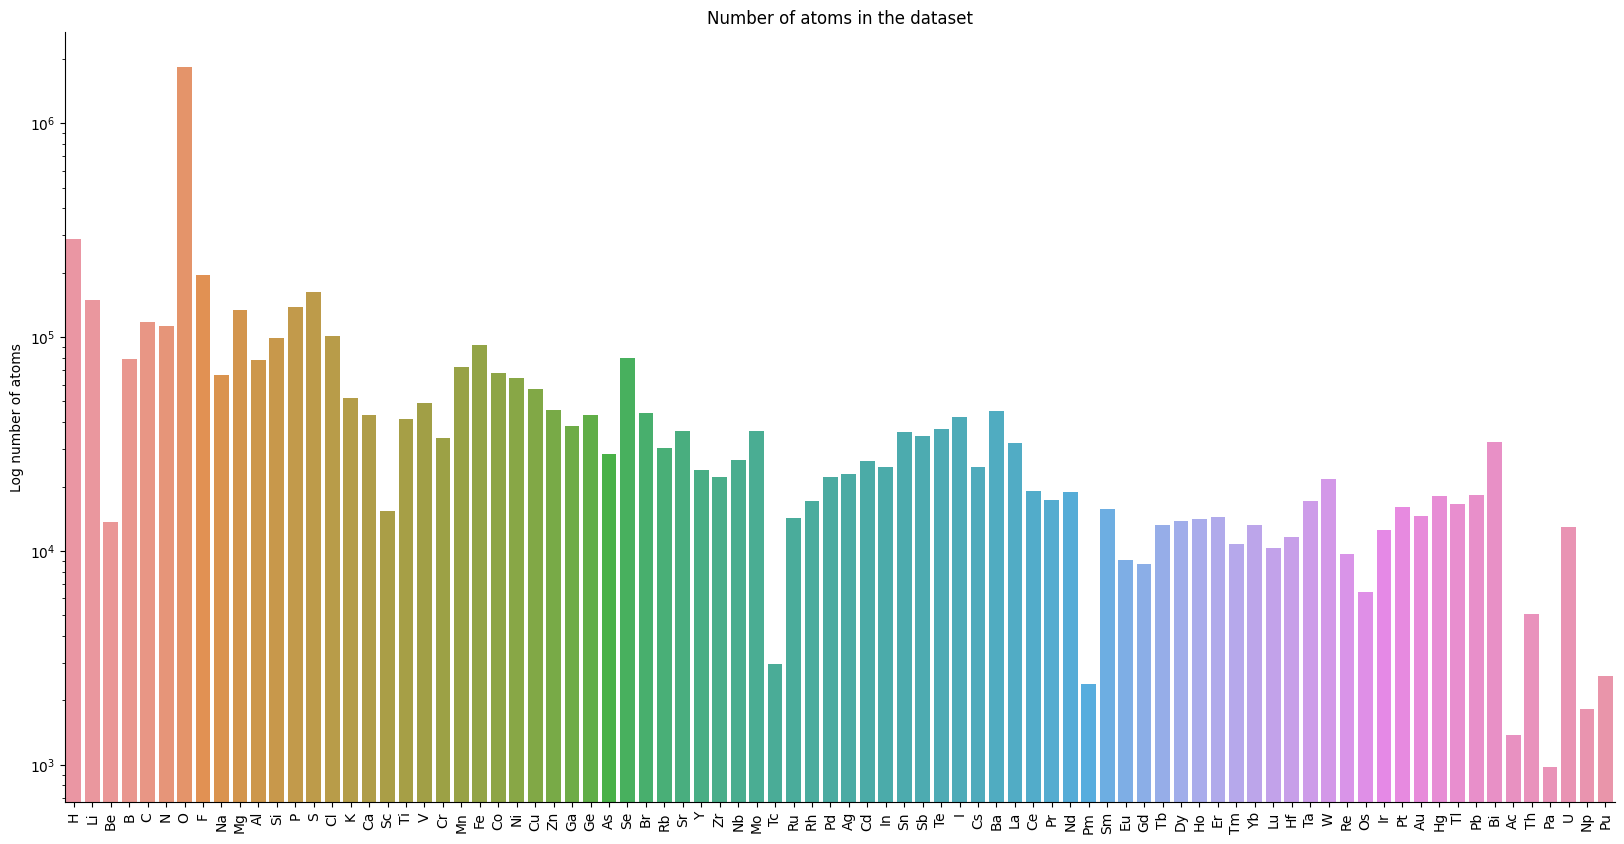

In [9]:
plt.figure(figsize=(20, 10))
sns.barplot(x=els_cols, y=els_sum)
plt.xticks(rotation=90)
plt.ylabel("Log number of atoms")
plt.title((title := "Number of atoms in the dataset"))
plt.yscale("log")
sns.despine()
plt.savefig(f"plots/matbench_eda/{minihash(title)}.jpg", dpi=250, bbox_inches="tight")

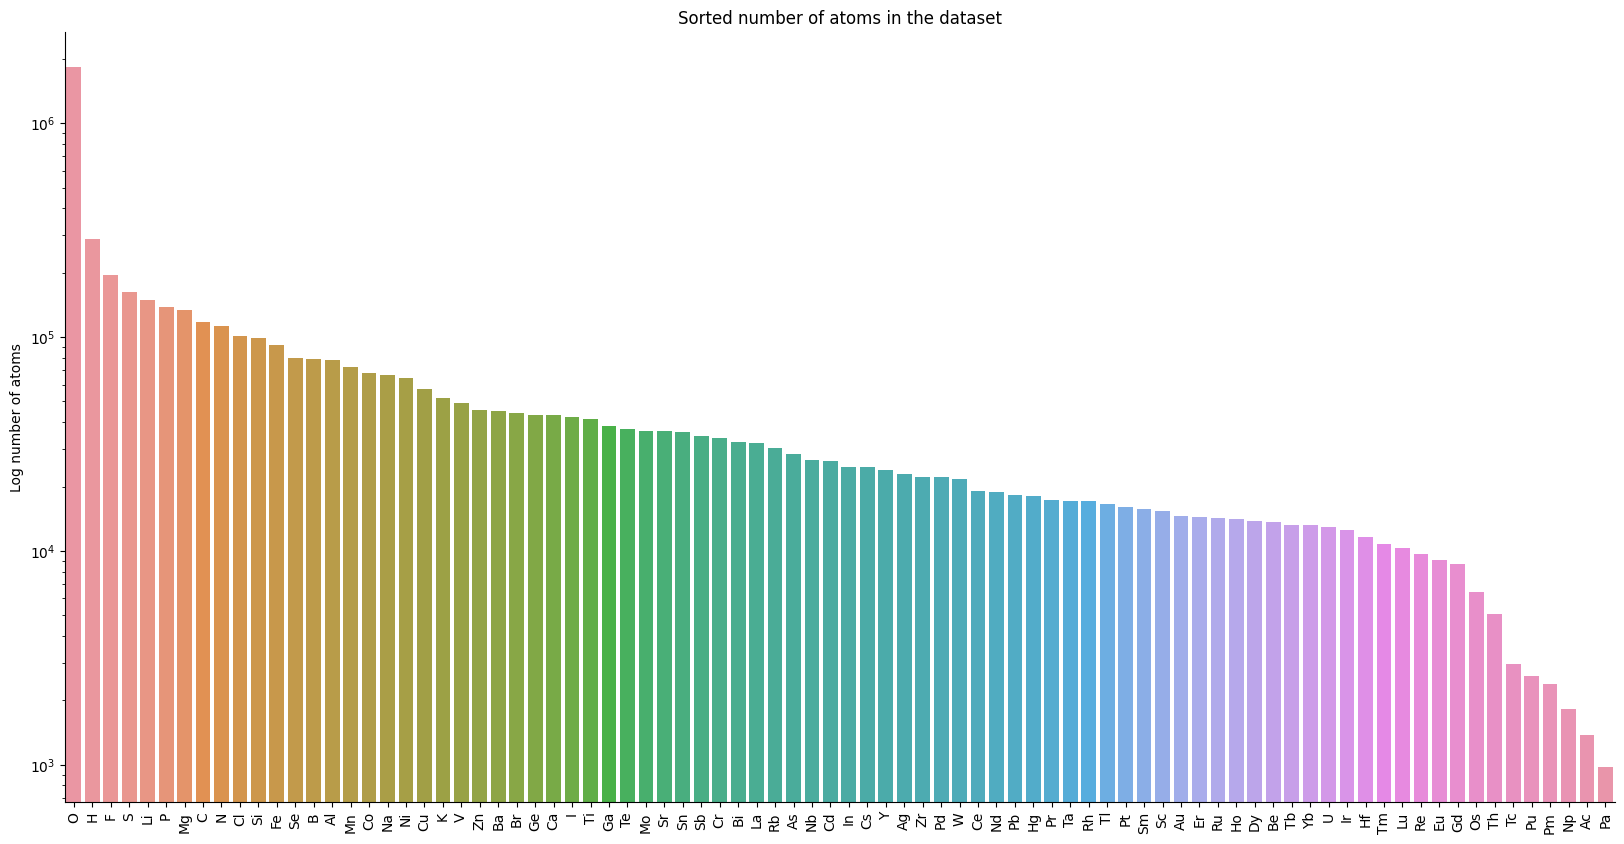

In [10]:
sort_idx = np.argsort(els_sum)[::-1]
sorted_els_cols = np.array(els_cols)[sort_idx]
sorted_els_sum = els_sum[sort_idx]

plt.figure(figsize=(20, 10))
sns.barplot(x=sorted_els_cols, y=sorted_els_sum)
plt.xticks(rotation=90)
plt.ylabel("Log number of atoms")
plt.title((title := "Sorted number of atoms in the dataset"))
plt.yscale("log")
sns.despine()
plt.savefig(f"plots/matbench_eda/{minihash(title)}.jpg", dpi=250, bbox_inches="tight")

In [11]:
edfint = edf.copy().astype(int)
if BINARIZE:
    diag = (edfint > 1).astype(int).sum(0)
    edfint = (edfint > 0).astype(int)
cooc_df = edfint.T.dot(edfint)
if BINARIZE:
    np.fill_diagonal(cooc_df.values, diag)

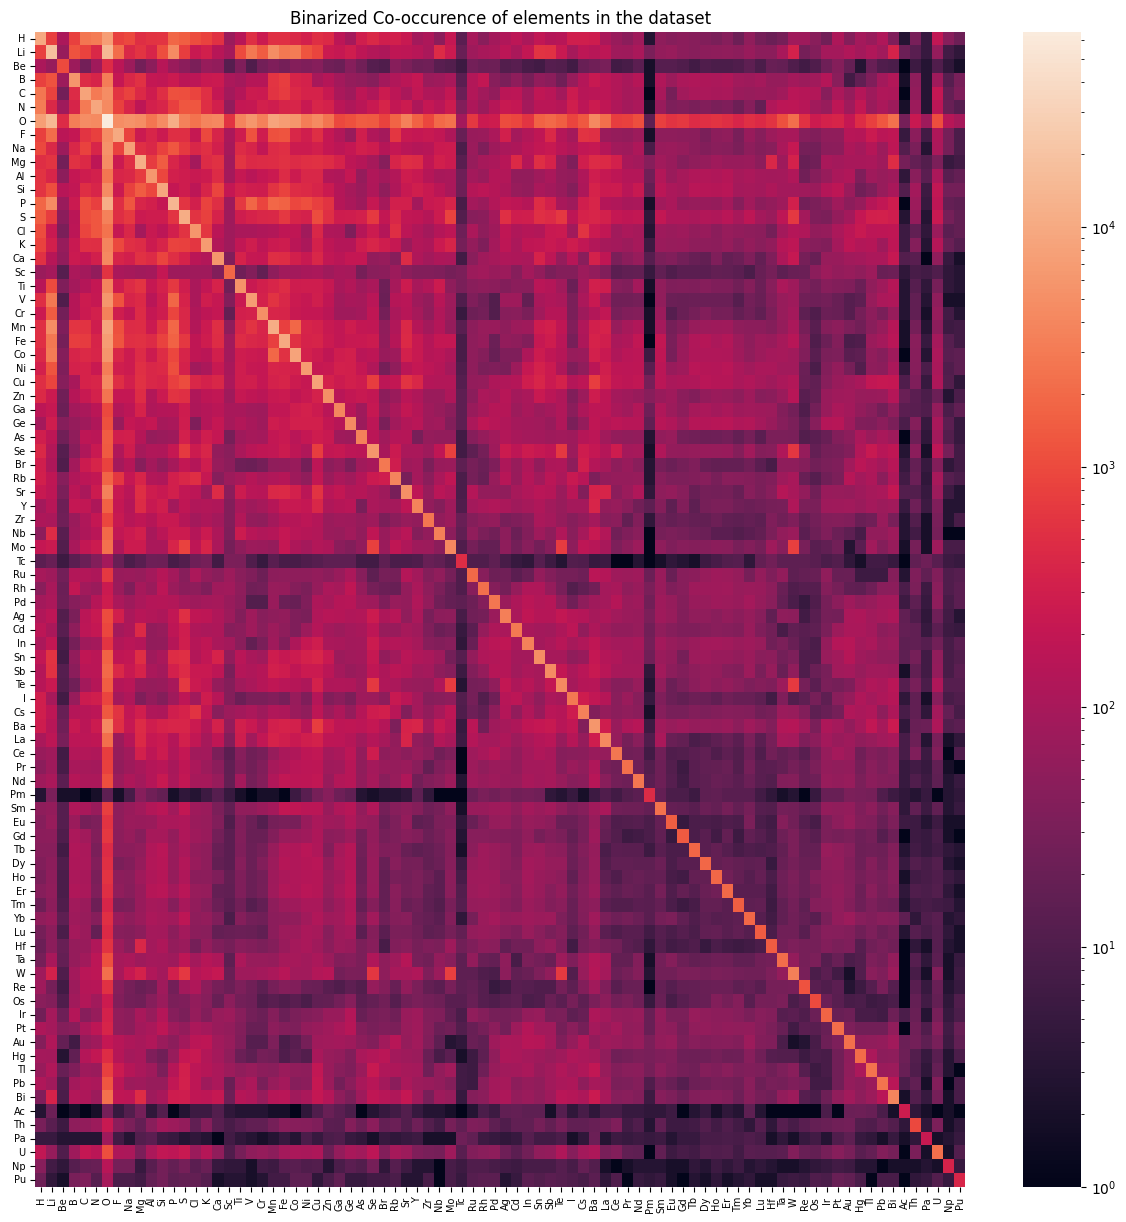

In [12]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(15, 15))
plot_data = cooc_df.values.copy()
if (plot_data == 0).any():
    plot_data = plot_data + 1
sns.heatmap(plot_data, xticklabels=els_cols, yticklabels=els_cols, norm=LogNorm())
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title(
    (
        title := ("Binarized " if BINARIZE else "")
        + "Co-occurence of elements in the dataset"
    )
)
plt.savefig(f"plots/matbench_eda/{minihash(title)}.jpg", dpi=250, bbox_inches="tight")

In [15]:
sorted_els_cols[:22]

array(['O', 'H', 'F', 'S', 'Li', 'P', 'Mg', 'C', 'N', 'Cl', 'Si', 'Fe',
       'Se', 'B', 'Al', 'Mn', 'Co', 'Na', 'Ni', 'Cu', 'K', 'V'],
      dtype='<U2')

Top 12 elements:  O, H, F, S, Li, P, Mg, C, N, Cl, Si, Fe


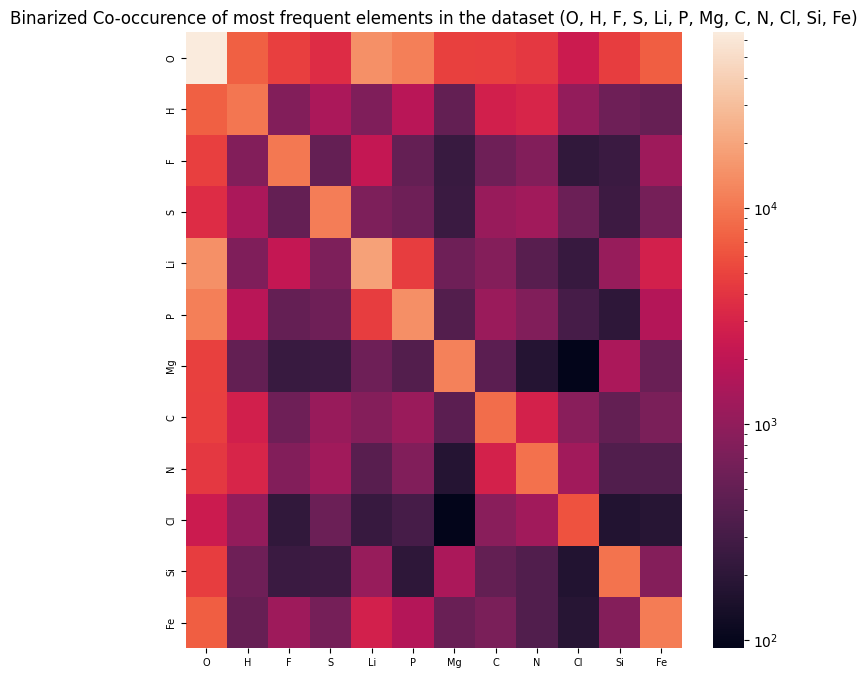

In [14]:
from matplotlib.colors import LogNorm

NMAX = 12
top_k_els = sorted_els_cols[:NMAX]
not_top_k_els = sorted_els_cols[NMAX:]
print(f"Top {NMAX} elements: ", ", ".join(top_k_els))
small_cooc_df = edfint[sorted_els_cols[:NMAX]].T.dot(edfint[sorted_els_cols[:NMAX]])

plot_data = small_cooc_df.values
if (plot_data == 0).any():
    plot_data = plot_data + 1

plt.figure(figsize=(8, 8))
sns.heatmap(
    plot_data,
    xticklabels=sorted_els_cols[:NMAX],
    yticklabels=sorted_els_cols[:NMAX],
    norm=LogNorm(),
)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title(
    (
        title := ("Binarized " if BINARIZE else "") +  f"Co-occurence of most frequent elements in the dataset ({', '.join(top_k_els)})"
    )
)
plt.savefig(f"plots/matbench_eda/{minihash(title)}.jpg", dpi=150, bbox_inches="tight")

In [44]:
most_occurring = cooc_df.values.ravel().argsort()[::-1]
rows, cols = most_occurring // len(cooc_df), most_occurring % len(cooc_df)
print("Most occuring pairs of elements:" + (" (binarized)" if BINARIZE else ""))
els_pairs = {}
for k, (r, c) in enumerate(zip(rows, cols)):
    el1 = cooc_df.index[r]
    el2 = cooc_df.columns[c]
    els_pairs[el1] = 1
    els_pairs[el2] = 1
    pair_not_single = set(els_pairs.keys()) - set(top_k_els)
    single_not_pair = set(top_k_els) - set(els_pairs.keys())
    print(
        f"{cooc_df.index[r]:2}",
        f"{cooc_df.columns[c]:2}",
        f"{cooc_df.values[r, c]:9}",
        f" | In co-occurrences, not in top {NMAX}: {', '.join(pair_not_single)}",
        f" | In top {NMAX}, not in co-occurrences: {', '.join(single_not_pair)}",
    )
    if len(els_pairs) >= NMAX and not single_not_pair:
        non_top_k = [
            f"{el} ({sorted_els_cols.tolist().index(el) + 1}th)"
            for el in pair_not_single
        ]
        print(f"\nStop: found all top {NMAX} elements. Total elements seen: {len(els_pairs)}")
        print(f"Non-top {NMAX} elements in co-occurrences: {', '.join(non_top_k)}\n")
        break
print(f"{len(els_pairs)} Co-occuring individual species: {', '.join(els_pairs)}")
print(f"{NMAX} Most occurring individual species: {', '.join(top_k_els)}")

Most occuring pairs of elements: (binarized)
O  O      64851  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Li, Si, H, Cl, P, N
Li Li     18289  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
Li O      14711  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
O  Li     14711  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
P  P      13911  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
P  O      11261  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
O  P      11261  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
Mg Mg     11022  | In co-occurrences, not in top 12:   | In top 12, not in co-occurrences: F

In [45]:
most_occurring = cooc_df.values.ravel().argsort()[::-1]
rows, cols = most_occurring // len(cooc_df), most_occurring % len(cooc_df)
print("Most occuring pairs of elements:" + (" (binarized)" if BINARIZE else ""))
els_pairs = {}
for k, (r, c) in enumerate(zip(rows, cols)):
    el1 = cooc_df.index[r]
    el2 = cooc_df.columns[c]
    if el1 not in top_k_els or el2 not in top_k_els:
        if el1 not in top_k_els:
            print(f"{el1} not in top {NMAX}")
        if el2 not in top_k_els:
            print(f"{el2} not in top {NMAX}")
        break
    els_pairs[el1] = 1
    els_pairs[el2] = 1
    pair_not_single = set(els_pairs.keys()) - set(top_k_els)
    single_not_pair = set(top_k_els) - set(els_pairs.keys())
    print(
        f"{cooc_df.index[r]:2}",
        f"{cooc_df.columns[c]:2}",
        f"{cooc_df.values[r, c]:9}",
        f" | In top {NMAX}, not in co-occurrences: {', '.join(single_not_pair)}",
    )

non_top_k = [
    f"{el} ({sorted_els_cols.tolist().index(el) + 1}th)" for el in pair_not_single
]
print(f"\nStop: Found {len(els_pairs)} elements in top {NMAX} co-occurrences.")
print(f"Non-top {NMAX} elements in co-occurrences: {', '.join(non_top_k)}\n")
print(f"{len(els_pairs)} Co-occuring individual species: {', '.join(els_pairs)}")
print(f"{NMAX} Most occurring individual species: {', '.join(top_k_els)}")

Most occuring pairs of elements: (binarized)
O  O      64851  | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Li, Si, H, Cl, P, N
Li Li     18289  | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
Li O      14711  | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
O  Li     14711  | In top 12, not in co-occurrences: Mg, Fe, F, C, S, Si, H, Cl, P, N
P  P      13911  | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
P  O      11261  | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
O  P      11261  | In top 12, not in co-occurrences: Mg, Fe, C, F, S, Si, H, Cl, N
Mg Mg     11022  | In top 12, not in co-occurrences: Fe, C, F, S, Si, H, Cl, N
S  S      10904  | In top 12, not in co-occurrences: Fe, C, F, Si, H, Cl, N
Mn not in top 12
Mn not in top 12

Stop: Found 5 elements in top 12 co-occurrences.
Non-top 12 elements in co-occurrences: 

5 Co-occuring individual species: O, Li, P, Mg, S
12 Most occurring individual

In [47]:
all_pairs = []
for k, (r, c) in enumerate(zip(rows, cols)):
    el1 = cooc_df.index[r]
    el2 = cooc_df.columns[c]
    pair = tuple(sorted([el1, el2]))
    if pair not in all_pairs:
        all_pairs.append((pair, cooc_df.values[r, c]))
        print(f"{el1} {el2} {cooc_df.values[r, c]}")
    if len(all_pairs) >= NMAX:
        print(f"Stop: found all top {NMAX} pairs.")
        break
top_k = [f"{a}-{b} ({c})" for (a, b), c in all_pairs]
print(f"Top {NMAX} co-occuring pairs of species: {', '.join(top_k)}")
print(f"Total atoms", sum([c for _, c in all_pairs]), "/", cooc_df.values.sum())

O O 64851
Li Li 18289
Li O 14711
O Li 14711
P P 13911
P O 11261
O P 11261
Mg Mg 11022
S S 10904
Mn Mn 10663
F F 9966
Fe Fe 9960
Stop: found all top 12 pairs.
Top 12 co-occuring pairs of species: O-O (64851), Li-Li (18289), Li-O (14711), Li-O (14711), P-P (13911), O-P (11261), O-P (11261), Mg-Mg (11022), S-S (10904), Mn-Mn (10663), F-F (9966), Fe-Fe (9960)
Total atoms 201510 / 1567994


In [28]:
edfint

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132747,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
132748,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132749,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
132750,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


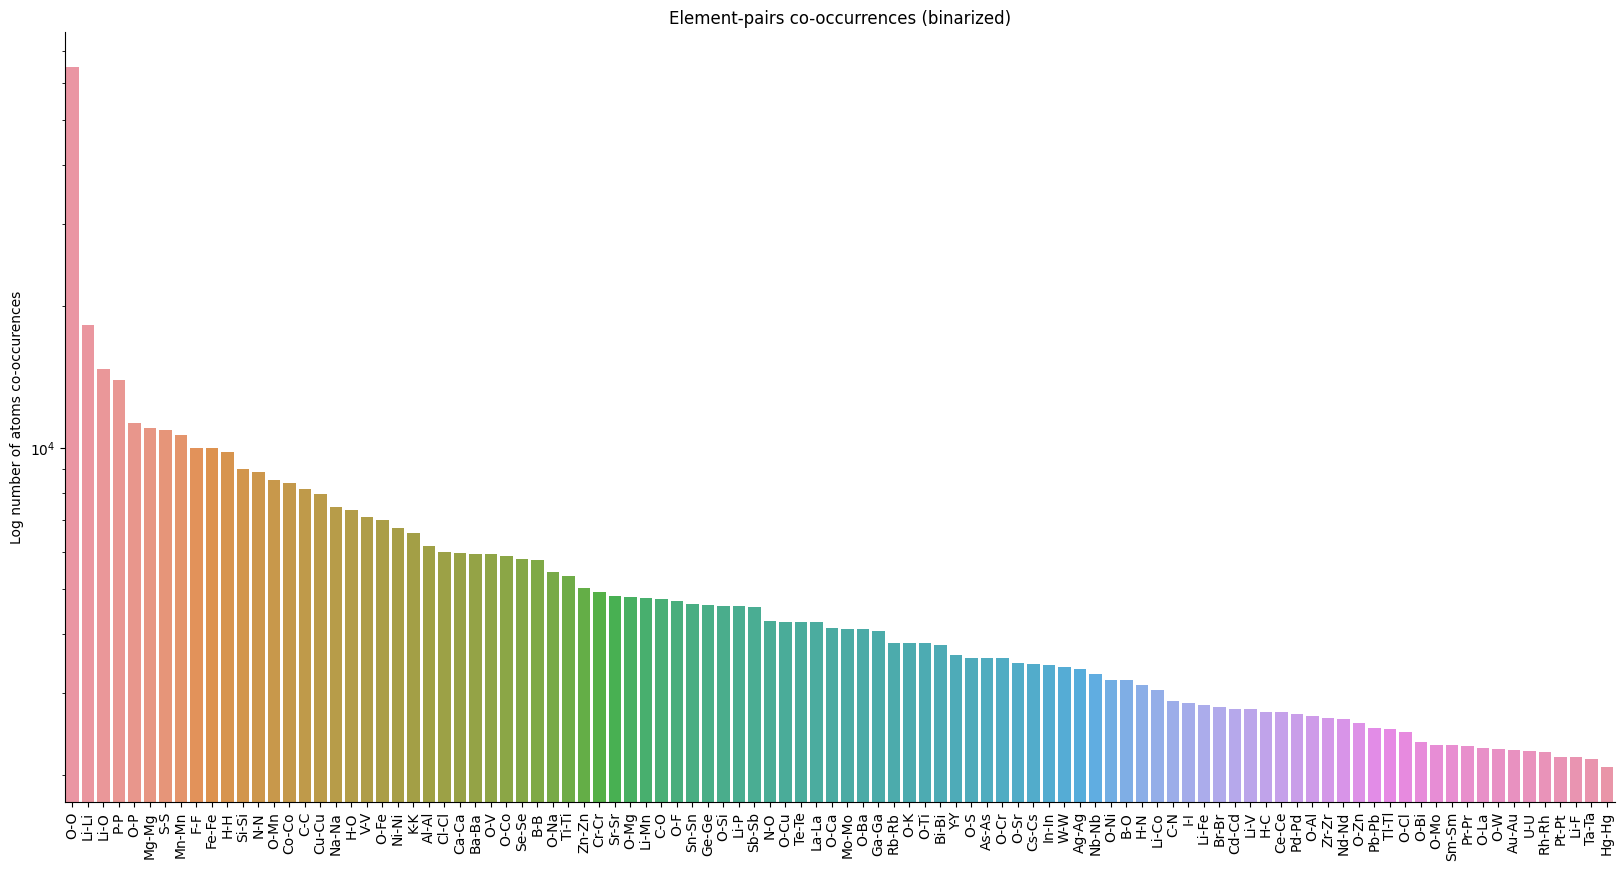

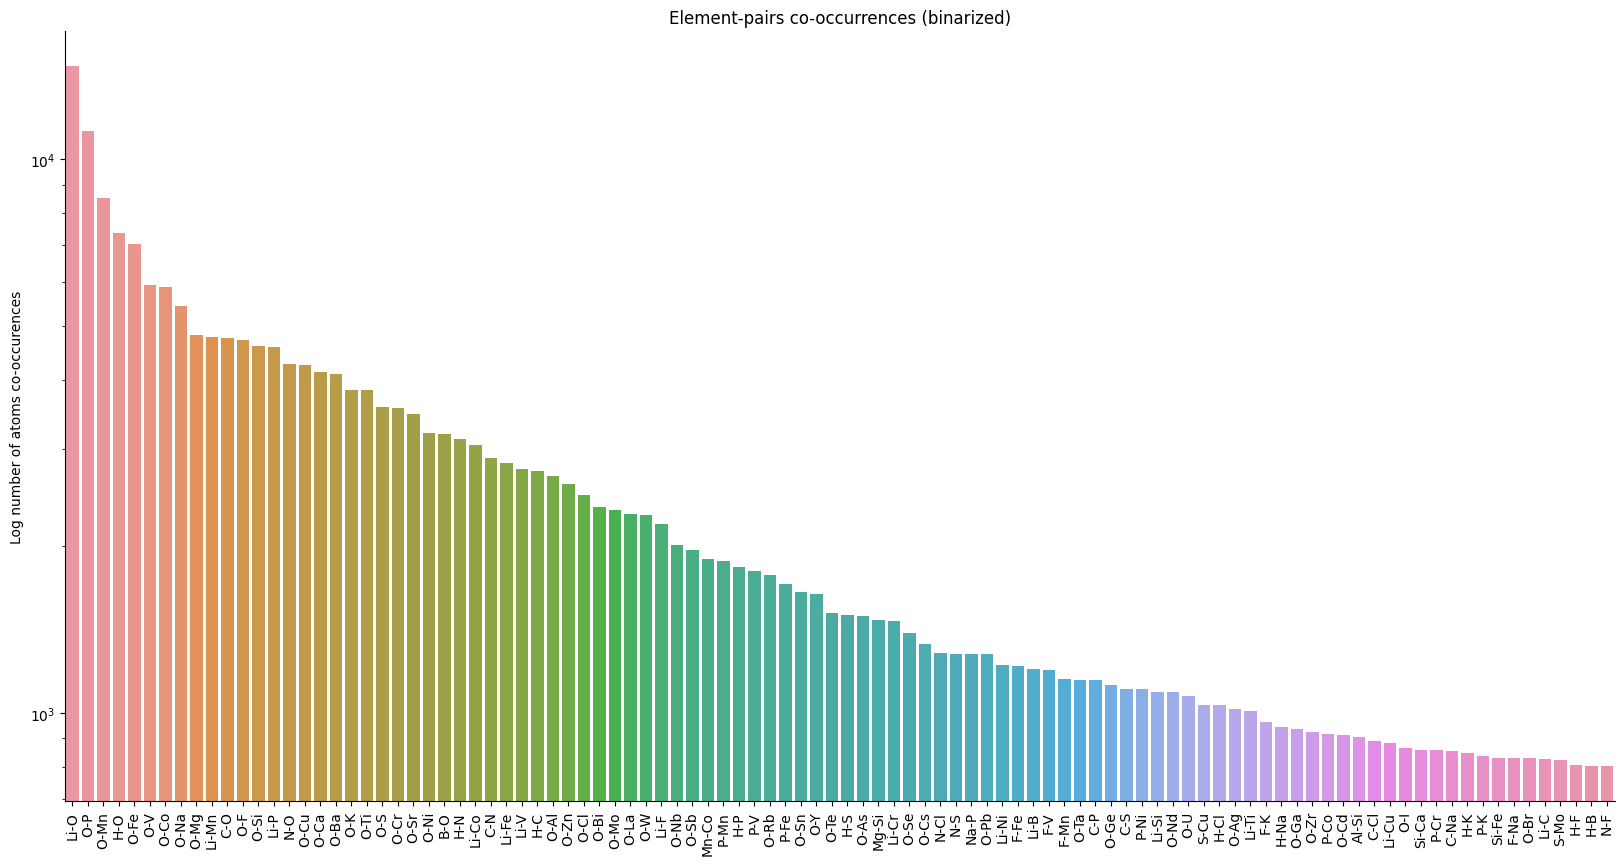

In [36]:
n_coocs = 100

for with_diag in [True, False]:
    small_coocs_df = cooc_df.copy()
    small_coocs_df[np.tril(np.ones_like(cooc_df.values, dtype=bool), k=-1 if with_diag else 0)] = -1
    most_occurring = small_coocs_df.values.ravel().argsort()[::-1][:n_coocs]
    rows, cols = most_occurring // len(small_coocs_df), most_occurring % len(small_coocs_df)
    coocs_labels = [f"{a}-{b}" for a, b in zip(small_coocs_df.index[rows], small_coocs_df.columns[cols])]
    bar_heights = small_coocs_df.values.ravel()[most_occurring]

    plt.figure(figsize=(20, 10))
    sns.barplot(x=coocs_labels, y=bar_heights)
    plt.xticks(rotation=90)
    plt.ylabel("Log number of atoms co-occurences")
    plt.title((title := "Element-pairs co-occurrences" + (" (binarized)" if BINARIZE else "")))
    plt.yscale("log")
    sns.despine()
    plt.savefig(f"plots/matbench_eda/{minihash(title)}-{'diag' if with_diag else 'no-diag'}.jpg", dpi=250, bbox_inches="tight")


In [51]:
edf[top_k_els].values.sum() / edf.values.sum()

0.6340862375013376

In [62]:
n_samples = []
for k in range(1, len(sorted_els_cols)):
    ns = (edf[sorted_els_cols[k:]].sum(1) == 0).sum()
    n_samples.append(ns)
    print(f"Number of samples with only the top-{k} elements: ", ns)
    print("  Elements:", ", ".join(sorted_els_cols[:k]))
    print()

Number of samples with only the top-1 elements:  20
  Elements: O

Number of samples with only the top-2 elements:  58
  Elements: O, H

Number of samples with only the top-3 elements:  71
  Elements: O, H, F

Number of samples with only the top-4 elements:  152
  Elements: O, H, F, S

Number of samples with only the top-5 elements:  211
  Elements: O, H, F, S, Li

Number of samples with only the top-6 elements:  320
  Elements: O, H, F, S, Li, P

Number of samples with only the top-7 elements:  558
  Elements: O, H, F, S, Li, P, Mg

Number of samples with only the top-8 elements:  838
  Elements: O, H, F, S, Li, P, Mg, C

Number of samples with only the top-9 elements:  1658
  Elements: O, H, F, S, Li, P, Mg, C, N

Number of samples with only the top-10 elements:  1991
  Elements: O, H, F, S, Li, P, Mg, C, N, Cl

Number of samples with only the top-11 elements:  3419
  Elements: O, H, F, S, Li, P, Mg, C, N, Cl, Si

Number of samples with only the top-12 elements:  6132
  Elements: O, 

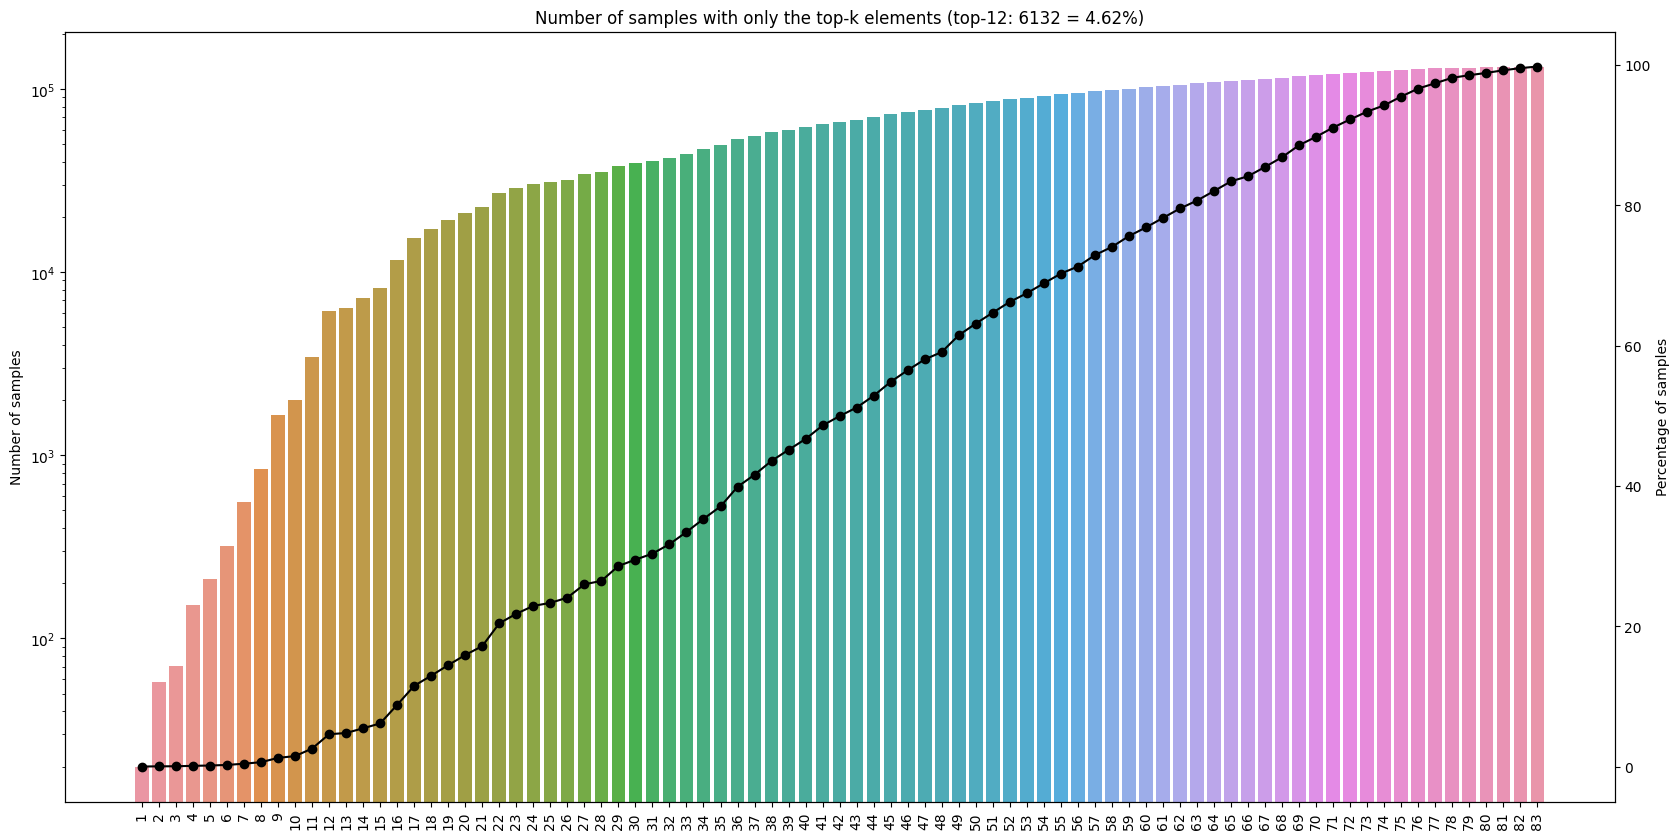

In [78]:
percents = np.array(n_samples) / len(edf) * 100
plt.figure(figsize=(20, 10))
g = sns.barplot(x=np.arange(1, len(sorted_els_cols)), y=n_samples)
g.set_ylabel("Number of samples")
g.set_yscale("log")
# second axis
g2 = g.twinx()
g2.plot(np.arange(len(sorted_els_cols) - 1), percents, color="black", marker="o")
# second axis y label
g2.set_ylabel("Percentage of samples")

g.set_xticklabels(np.arange(1, len(sorted_els_cols)), rotation=90)
plt.title((title := "Number of samples with only the top-k elements" + f" (top-{NMAX}: {n_samples[NMAX-1]} = {percents[NMAX-1]:.2f}%)"))
plt.xlabel("k")
plt.savefig(f"plots/matbench_eda/{minihash(title)}.jpg", dpi=250, bbox_inches="tight")